<a href="https://colab.research.google.com/github/javier06github/Desafio_ONE_TelecomX/blob/main/TelecomX_LATAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1️⃣ 📁 Carga y exploración inicial del dataset

In [30]:
import pandas as pd

# Montar Google Drive y cargar CSV desde la ruta correspondiente
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TelecomX_Limpio.csv")  # Actualizar la ruta si es necesario

# Vista previa
print("Shape:", df.shape)
print("\nValores faltantes por columna:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\nPrimeras filas:")
print(df.head())


Shape: (7267, 22)

Valores faltantes por columna:
churn                    224
account.charges.total     11
dtype: int64

Primeras filas:
   customerid  churn customer.gender  customer.seniorcitizen  \
0  0002-orfbo    0.0          female                       0   
1  0003-mknfe    0.0            male                       0   
2  0004-tlhlj    1.0            male                       0   
3  0011-igkff    1.0            male                       1   
4  0013-exchz    1.0          female                       1   

   customer.partner  customer.dependents  customer.tenure  phone.phoneservice  \
0                 1                    1                9                   1   
1                 0                    0                9                   1   
2                 0                    0                4                   1   
3                 1                    0               13                   1   
4                 1                    0                3               

# 🧹 Limpieza y preprocesamiento de los datos
# (Agregar detección y eliminación de duplicados, valores no consistentes, etc.)

# Verificación de la proporción de cancelación (churn)
print("
📊 Proporción de cancelaciones:")

In [31]:
# Verificación de la proporción de cancelación (churn)
print("\n📊 Proporción de cancelaciones:")
print(df['churn'].value_counts(normalize=True))

# Eliminar columnas que no aportan valor predictivo (por ejemplo, ID del cliente)
df.drop(columns=["customerid"], inplace=True)


📊 Proporción de cancelaciones:
churn
0.0    0.73463
1.0    0.26537
Name: proportion, dtype: float64



# 3️⃣ ❌ Tratamiento de nulos y outliers

In [32]:
# Eliminar registros con target (churn) o cargos totales nulos
df = df[df['churn'].notna()]
df = df[df['account.charges.total'].notna()]

# Confirmar limpieza de nulos
print("Nulos restantes:", df.isnull().sum().sum())
print("Forma del DataFrame después de limpieza:", df.shape)
# ---

Nulos restantes: 0
Forma del DataFrame después de limpieza: (7032, 21)


# 4️⃣ 🔤 Codificación de variables categóricas


In [33]:
from sklearn.preprocessing import OneHotEncoder

nominal_cols = ['account.contract', 'account.paymentmethod', 'internet.internetservice']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = pd.DataFrame(encoder.fit_transform(df[nominal_cols]),
                       columns=encoder.get_feature_names_out(nominal_cols),
                       index=df.index)

df = pd.concat([df.drop(columns=nominal_cols), encoded], axis=1)

# ---


# 5️⃣ 🔍 Análisis de correlación y selección de variables

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


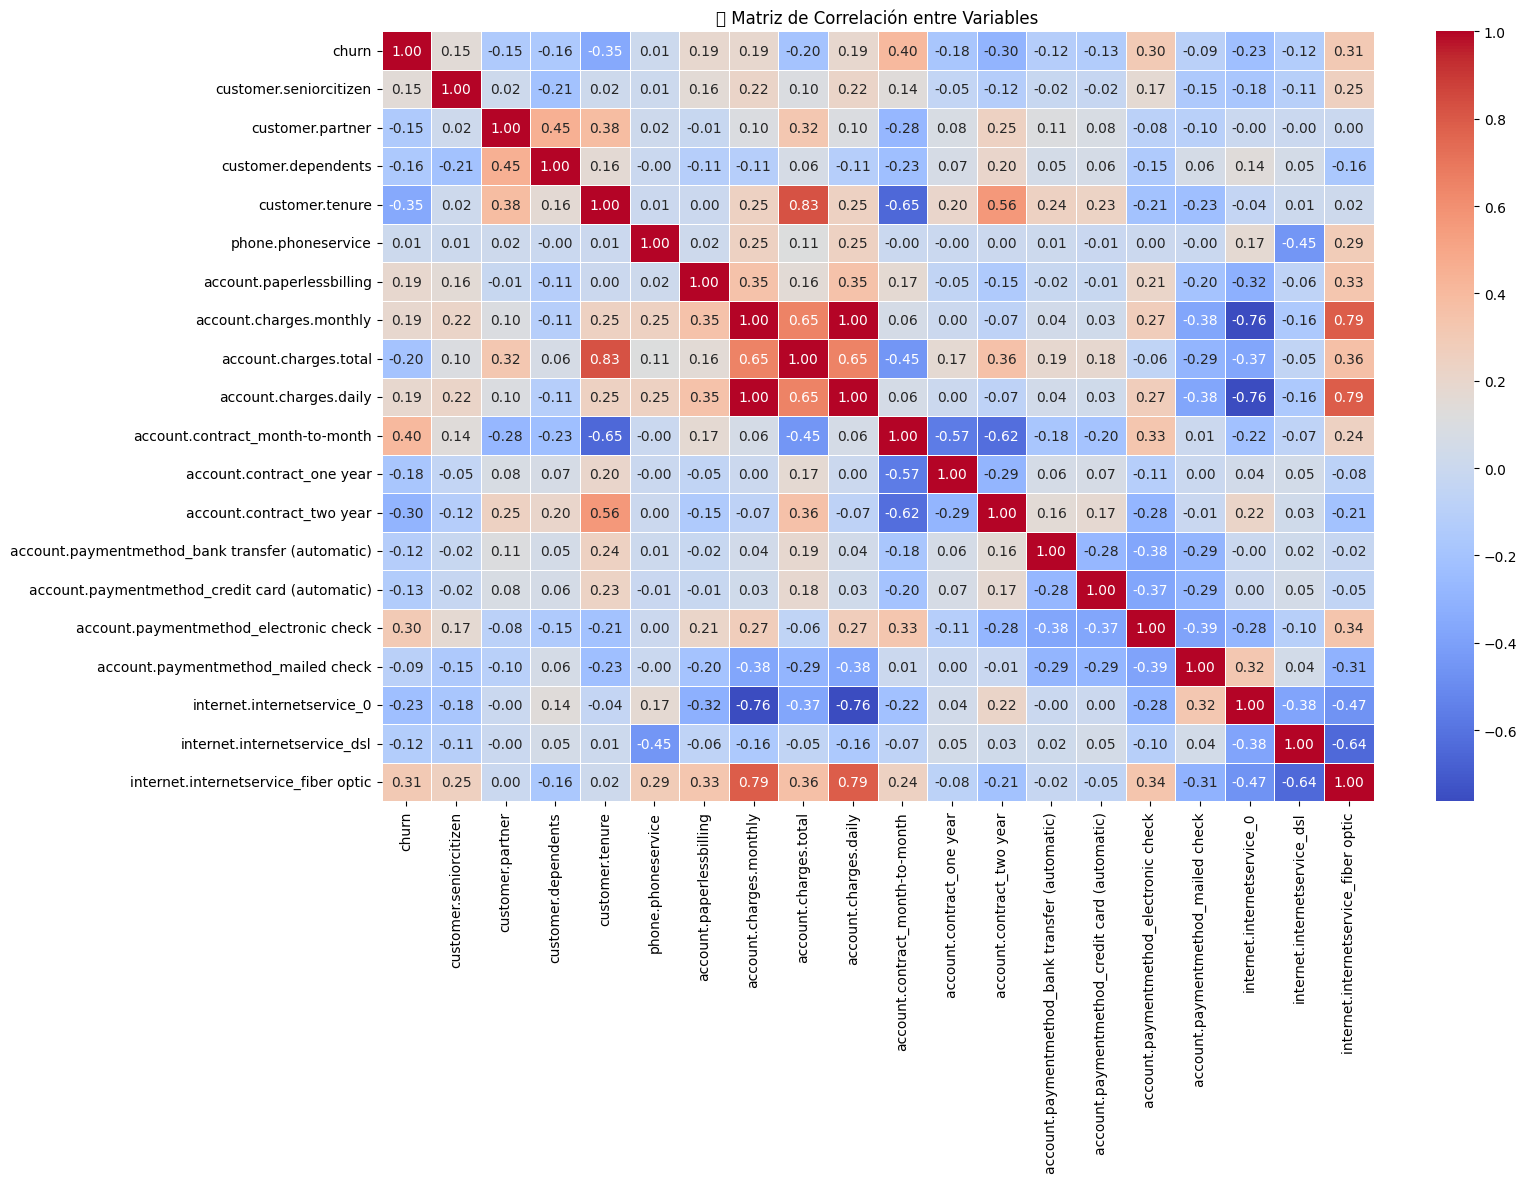


📌 Correlación de cada variable con 'churn':
churn                                              1.000000
account.contract_month-to-month                    0.404565
internet.internetservice_fiber optic               0.307463
account.paymentmethod_electronic check             0.301455
account.charges.daily                              0.192914
account.charges.monthly                            0.192858
account.paperlessbilling                           0.191454
customer.seniorcitizen                             0.150541
phone.phoneservice                                 0.011691
account.paymentmethod_mailed check                -0.090773
account.paymentmethod_bank transfer (automatic)   -0.118136
internet.internetservice_dsl                      -0.124141
account.paymentmethod_credit card (automatic)     -0.134687
customer.partner                                  -0.149982
customer.dependents                               -0.163128
account.contract_one year                         -0.17

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar matriz de correlación
plt.figure(figsize=(16, 10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('🔍 Matriz de Correlación entre Variables')
plt.show()

# Ordenar correlaciones con churn
print("\n📌 Correlación de cada variable con 'churn':")
print(corr_matrix['churn'].sort_values(ascending=False))

# 6️⃣ 📊 Análisis dirigido de variables relevantes


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


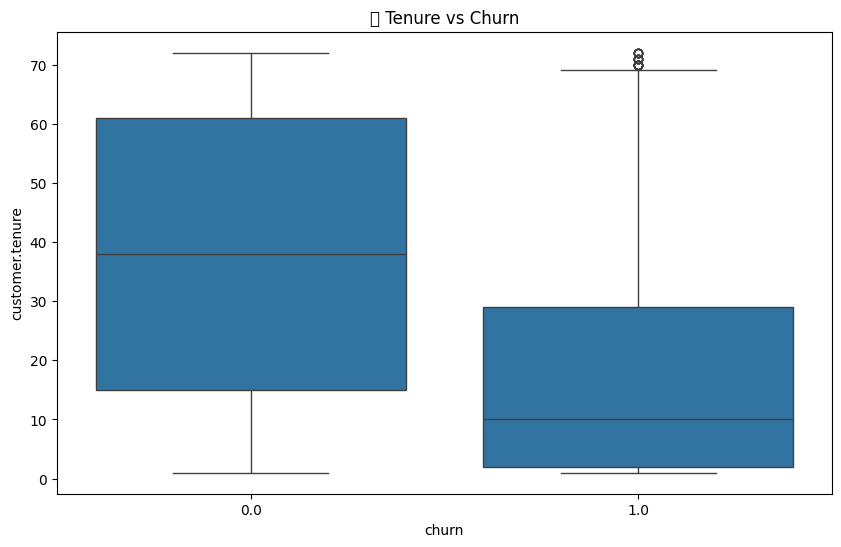

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


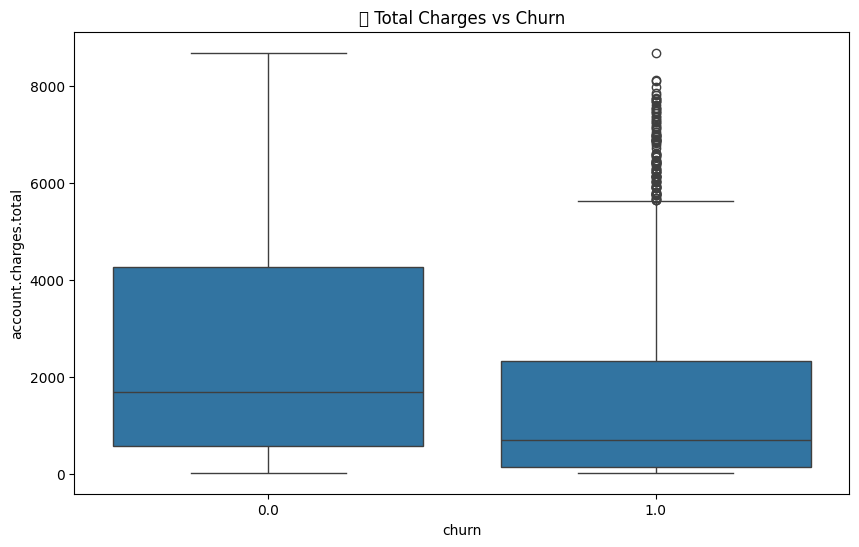

In [39]:
# ⏳ Tiempo de contrato vs churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='customer.tenure', data=df)
plt.title('⏳ Tenure vs Churn')
plt.show()

# 💰 Cargos totales vs churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='account.charges.total', data=df)
plt.title('💰 Total Charges vs Churn')
plt.show()

# ---

# 7️⃣ 🤖 Entrenamiento de modelos de clasificación

In [42]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

# Separar variables predictoras (X) y variable objetivo (y)
X = df.drop(columns=['churn'])
y = df['churn']

# Dividir en conjunto de entrenamiento y prueba (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Detectar columnas categóricas no codificadas
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Reaplicar codificación si quedaron columnas categóricas
if categorical_cols:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Escalado solo para modelos que lo requieren
escalador = StandardScaler()
X_train_res_scaled = escalador.fit_transform(X_train_res)
X_test_scaled = escalador.transform(X_test)

# Entrenar modelos
model_rf = RandomForestClassifier(random_state=42)
model_dt = DecisionTreeClassifier(random_state=42)
model_lr = LogisticRegression(max_iter=1000, random_state=42)

model_rf.fit(X_train_res, y_train_res)
model_dt.fit(X_train_res, y_train_res)
model_lr.fit(X_train_res_scaled, y_train_res)

# Mostrar proporciones y verificación del escalado
print("Proporción original de entrenamiento:")
print(y_train.value_counts(normalize=True))
print("\nProporción después de SMOTE:")
print(y_train_res.value_counts(normalize=True))

import numpy as np
print("\nMedia post-escalado (train):", round(np.mean(X_train_res_scaled), 4))
print("Desvío estándar post-escalado (train):", round(np.std(X_train_res_scaled), 4))


Proporción original de entrenamiento:
churn
0.0    0.734254
1.0    0.265746
Name: proportion, dtype: float64

Proporción después de SMOTE:
churn
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64

Media post-escalado (train): -0.0
Desvío estándar post-escalado (train): 1.0


# 8️⃣ 📊 Evaluación de modelos con métricas adecuadas

In [43]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Función para evaluar y mostrar resultados
def evaluar_modelo(nombre, modelo, X_test_data, y_test_data):
    print(f"\n🔍 Evaluación del modelo: {nombre}")
    y_pred = modelo.predict(X_test_data)
    print("📊 Matriz de confusión:")
    print(confusion_matrix(y_test_data, y_pred))
    print("\n📋 Reporte de clasificación:")
    print(classification_report(y_test_data, y_pred))
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test_data)[:, 1]
        auc = roc_auc_score(y_test_data, y_proba)
        print(f"🎯 ROC-AUC: {auc:.2f}")

# Evaluar modelos
evaluar_modelo("Random Forest", model_rf, X_test, y_test)
evaluar_modelo("Decision Tree", model_dt, X_test, y_test)
evaluar_modelo("Logistic Regression", model_lr, X_test_scaled, y_test)



🔍 Evaluación del modelo: Random Forest
📊 Matriz de confusión:
[[1373  176]
 [ 285  276]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1549
         1.0       0.61      0.49      0.54       561

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110

🎯 ROC-AUC: 0.82

🔍 Evaluación del modelo: Decision Tree
📊 Matriz de confusión:
[[1228  321]
 [ 266  295]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.82      0.79      0.81      1549
         1.0       0.48      0.53      0.50       561

    accuracy                           0.72      2110
   macro avg       0.65      0.66      0.65      2110
weighted avg       0.73      0.72      0.73      2110

🎯 ROC-AUC: 0.66

🔍 Evaluación del modelo: Logistic Regression
📊 Matriz de confusión:
[[1128 

# 9️⃣ 🧠 Interpretación del modelo (feature importance, etc.)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


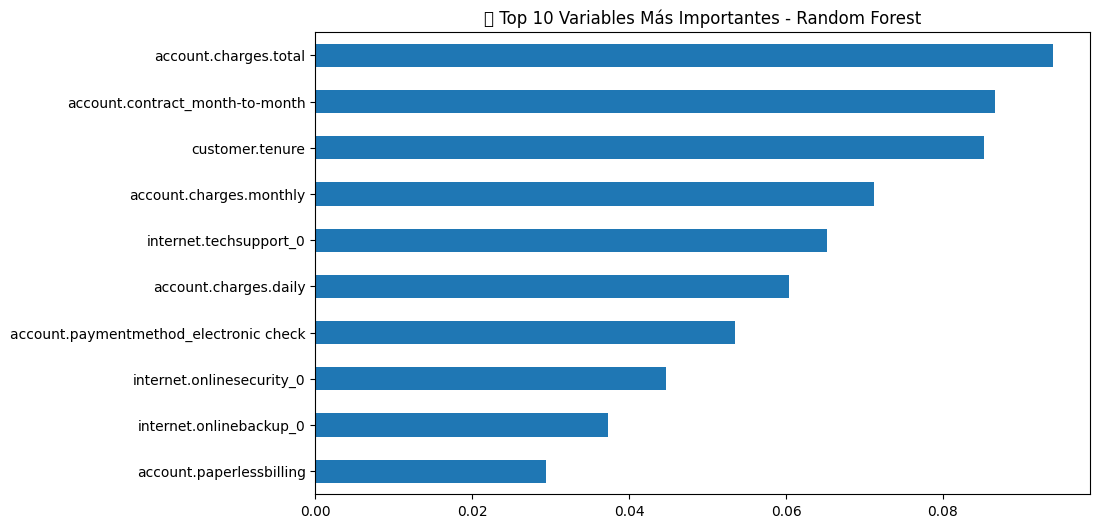

In [46]:
# 🔍 Importancia de variables - Random Forest (corregido)
# Recuperar nombres reales tras codificación
if categorical_cols:
    encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names = list(encoded_feature_names) + list(X.select_dtypes(exclude='object').columns)
else:
    feature_names = X.columns.tolist()

importances_rf = pd.Series(model_rf.feature_importances_, index=feature_names)
importances_rf_sorted = importances_rf.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances_rf_sorted.head(10).plot(kind='barh')
plt.title('🌲 Top 10 Variables Más Importantes - Random Forest')
plt.gca().invert_yaxis()
plt.show()


# 🔟 📝 Conclusión estratégica con recomendaciones


# 🎯 Conclusiones del Análisis Predictivo de Cancelación (Churn)

# 🔹 Principales hallazgos:
# - La variable más relevante en Random Forest fue 'account.contract_month-to-month', indicando que los contratos mensuales se asocian más a la cancelación.
# - En regresión logística, el 'paperless billing', el método de pago 'electronic check', y el menor tenure (antigüedad) también se destacaron como factores de riesgo.

# 📈 Evaluación de modelos:
# - Random Forest obtuvo un ROC-AUC de 0.82 con buena precisión general, aunque menor recall para la clase minoritaria (clientes que cancelan).
# - Logistic Regression logró un mayor recall (0.80) para la clase 1 (cancelación), lo que es útil si se quiere minimizar falsos negativos.

# 💡 Recomendaciones estratégicas:
# - Incentivar contratos de mayor plazo, como 'one year' o 'two year'.
# - Revisar políticas de clientes con facturación sin papel y pago por 'electronic check'.
# - Enfocar acciones de retención en clientes con baja antigüedad (tenure < 12 meses).
# - Implementar alertas tempranas y programas de fidelización.

# 🔄 Posibles mejoras futuras:
# - Incluir más variables comportamentales (uso del servicio, reclamos, etc.).
# - Probar modelos más complejos (XGBoost, redes neuronales).
# - Validación cruzada y tuning de hiperparámetros para mejorar robustez.
